This example is primarily concerned with loading raw data. This data is often not fully pre-processed (e.g. neuroids that we don't trust are not filtered, repetitions are not averaged, hard stimuli are not pre-selected etc.).

If you only want to compare data with each other, you are probably better off 
using benchmarks directly (e.g. `from brainscore import benchmarks; benchmarks.load('dicarlo.MajajHong2015')`) or
loading the data through benchmarks (e.g. `from brainscore import benchmarks; benchmarks.load_assembly('dicarlo.MajajHong2015')`).

### Neural assembly

We can load data (called "assembly") using the `get_assembly` method.
In the following, we load neural data from the DiCarlo lab, published in Majaj, Hong et al. 2015.


In [1]:
import brainscore
neural_data = brainscore.get_assembly(name="dicarlo.MajajHong2015.public")
neural_data

<xarray.NeuronRecordingAssembly 'dicarlo.Majaj2015.public' (neuroid: 256, presentation: 148480, time_bin: 1)>
array([[[ 0.060929],
        [-0.847906],
        ...,
        [-0.832111],
        [-0.832111]],

       [[-0.725592],
        [ 0.895499],
        ...,
        [-1.158598],
        [-0.795479]],

       ...,

       [[ 0.280502],
        [-1.18722 ],
        ...,
        [ 0.077538],
        [-0.614134]],

       [[ 0.307263],
        [ 0.353218],
        ...,
        [ 1.005235],
        [-0.298961]]], dtype=float32)
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (n

This gives us a NeuronRecordingAssembly, a sub-class of xarray DataArray.
The behavioral and neural assemblies are always handled with the xarray framework.
xarray data is basically a multi-dimensional table with annotating coordinates, similar to pandas. 
More info here: http://xarray.pydata.org.

The neural assembly `dicarlo.MajajHong2015.public`
is structured into the dimensions `neuroid x presentation`.
`neuroid` is a MultiIndex containing information about the recording site, such as the animal and the region.
`presentation` refers to the single presentation of a stimulus with coords annotating 
e.g. the image_id and the repetition.
Finally, `time_bin` informs us about the time in milliseconds from when neural responses were collected. 
This assembly contains averaged spike rates in the 70-170ms window.

The data is in a raw format, but typically we use a pre-processed version.
We can further process the data e.g. as follows: 

1. average across repetitions,

2. filter neuroids from the IT region,

3. get rid of the scalar time_bin dimension,

4. and reshape into `presentation x neuroid`.

In [2]:
compact_data = neural_data.multi_groupby(['category_name', 'object_name', 'image_id']).mean(dim='presentation')  # (1)
compact_data = compact_data.sel(region='IT')  # (2)
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.transpose('presentation', 'neuroid')  # (4)
compact_data

<xarray.NeuronRecordingAssembly 'dicarlo.Majaj2015.public' (presentation: 3200, neuroid: 168)>
array([[ 0.1962  ,  0.10559 ,  0.430899, ...,  0.254563, -0.103698,  0.400337],
       [-0.188017, -0.599624, -0.02469 , ...,  0.108069,  0.243771,  0.13458 ],
       [ 0.576654,  0.242336, -0.229085, ...,  0.312417, -0.155798,  0.012417],
       ...,
       [ 0.608051,  0.17681 , -0.110604, ...,  0.123359,  0.14819 ,  0.076451],
       [ 0.014948, -0.243371, -0.238544, ...,  0.593095,  0.112013, -0.267446],
       [-0.107264, -0.029414, -0.074609, ..., -0.297466,  0.482114,  0.243566]],
      dtype=float32)
Coordinates:
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr            (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M' 'M'
  - col            (neuroid) int64 9 9 8 9 8 8 7 7 5 6 4 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere     (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion      (neuroi

The data now contains 3200 images and the responses of 168 neuroids.

In [3]:
print(compact_data.shape)

(3200, 168)


Note that the data used for benchmarking is typically already pre-processed.
For instance, the target assembly for the public benchmark `MajajITPublicBenchmark`  
is the same as our pre-processed version here:

In [4]:
from brainscore.public_benchmarks import MajajITPublicBenchmark

benchmark = MajajITPublicBenchmark()
benchmark_assembly = benchmark._assembly
print(benchmark_assembly.shape)


(3200, 168)


### Stimulus Set

You may have noticed the attribute `stimulus_set` in the previous assembly.
A stimulus set contains the stimuli that were shown to measure the neural recordings.
Specifically, this entails e.g. the image_id and the object_name, packaged in a pandas DataFrame.

In [5]:
stimulus_set = neural_data.attrs['stimulus_set']
print(stimulus_set[:3])

   id                                  image_id  \
0   1  8a72e2bfdb8c267b57232bf96f069374d5b21832   
1   2  27f69468c9d6019ed0d22b9583c94c5b58198c1c   
2   3  6af1cbb28aacea6c582faa07e92d8325fa7a29d7   

                                     image_file_name object_name  \
0  astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...   car_astra   
1  _12_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty...      table3   
2  face0003_rx+00.000_ry+00.000_rz+00.000_tx+00.0...       face2   

  category_name                             background_id  variation   ty  \
0          Cars  ecd40f3f6d7a4d6d88134d648884e0b9b364efc9          0  0.0   
1        Tables  006d66c207c6417574f62f0560c6b2b40a9ec5a1          0  0.0   
2         Faces  3b3c1d65865028d0fad0b0bf8f305098db717e7f          0  0.0   

    tz  rxy  rxz  ryz  rxy_semantic  rxz_semantic  ryz_semantic   size    s  
0  0.0 -0.0  0.0 -0.0          90.0           0.0          -0.0  256.0  1.0  
1  0.0 -0.0  0.0 -0.0          -0.0           0.0        

We can also directly retrieve any image using the `get_image` method.

In [6]:
image_path = stimulus_set.get_image(stimulus_set['image_id'][0])
print(image_path)


/braintree/home/msch/.brainio/image_hvm_with_discfade/Variation00_20110203/astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_ty+00.000_s+01.000_ecd40f3f6d7a4d6d88134d648884e0b9b364efc9_256x256.png


Images are automatically downloaded locally and can thus be loaded and displayed directly.

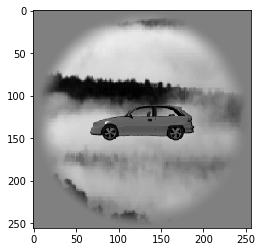

In [7]:
%matplotlib inline
from matplotlib import pyplot, image
img = image.imread(image_path)
pyplot.imshow(img)
pyplot.show()